In [1]:
import torch
torch.manual_seed(0)
ONEHOT=False
DATAPATH = '/home/skrhakv/deeplife/binding-prediction--deeplife-lab/data'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

### use dataset API to load the Yu dataset

In [4]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class YuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        if ONEHOT:
            self.Ys = F.one_hot(torch.tensor(Ys_list, dtype=torch.int64))
        else:
            self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


### proccess the Yu dataset

In [5]:
import csv

def proccess_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys

In [47]:
Xs_train, Ys_train = proccess_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/embeddings')

train_dataset = YuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = proccess_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/embeddings')

test_dataset = YuDataset(Xs_test, Ys_test)

In [48]:
print(len(train_dataset))
print(len(test_dataset))

102573
21013


### Define a classifier
Create a classifier to predict whether residue is part of a binding site

In [49]:
from torch import nn

DROPOUT = 0.3
LAYER_WIDTH = 100

class YuClassifier(nn.Module):
    def __init__(self, input_dim=2560):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


### Train imbalanced dataset
The dataset is heavily imbalanced (only ~5% of all residues are binding residues, the rest is non-binding), therefore we pass the `weight` argument for the loss function. But first, the weights need to be calculated using the `compute_class_weights(...)` function.

In [50]:
from sklearn.utils import class_weight

def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

torch.manual_seed(42)

### Train loop

In [54]:
from sklearn import metrics  

model_0 = YuClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):
    ### TRAIN
    model_0.train()

    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

Epoch: 0 | Loss: 1.84645, Accuracy: 54.82% | Test loss: 0.90682, AUC: 0.6447920522776224, MCC: 0.09431623124467593
Epoch: 10 | Loss: 0.91228, Accuracy: 77.94% | Test loss: 0.53689, AUC: 0.8862689415806663, MCC: 0.3288766222214396
Epoch: 20 | Loss: 0.65476, Accuracy: 86.89% | Test loss: 0.47271, AUC: 0.9161451521271524, MCC: 0.4003342637058067
Epoch: 30 | Loss: 0.53018, Accuracy: 89.13% | Test loss: 0.43135, AUC: 0.9292828650973491, MCC: 0.42867217471228386
Epoch: 40 | Loss: 0.44872, Accuracy: 90.94% | Test loss: 0.41120, AUC: 0.936858134802108, MCC: 0.45838484260740364
Epoch: 50 | Loss: 0.39609, Accuracy: 91.95% | Test loss: 0.39935, AUC: 0.9416165231984747, MCC: 0.4719211726208164
Epoch: 60 | Loss: 0.34801, Accuracy: 93.02% | Test loss: 0.39526, AUC: 0.944924321168143, MCC: 0.4839506169321163
Epoch: 70 | Loss: 0.30509, Accuracy: 93.72% | Test loss: 0.39823, AUC: 0.9470008652984346, MCC: 0.4968146687885479


### Compare train and test loss

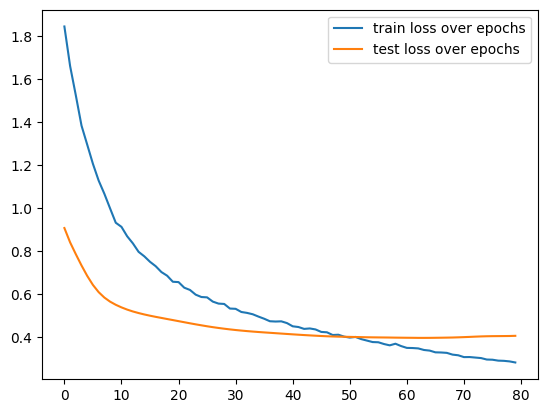

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

### ROC curve
The dataset is imbalanced, therefore it is important to use a more complex metrics for evaluating the model appart from using only the accuracy (if we would predict everything as NON-BINDING, then we would achieve ~95% accuracy as most of the residues are NON-BINDING!).

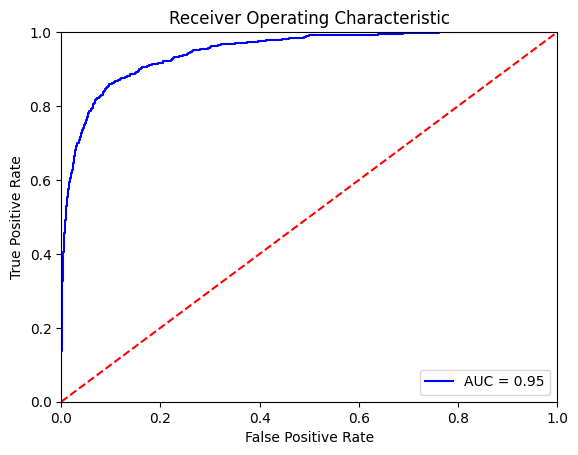

In [56]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Homework: Part 1
Create embeddings based on sequences from the annotation files using a different model (We'll give you hints for ProtBERT, but feel free to use model of your own choice - ProtT5, Ankh, ...)

In [6]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")

GENERATE_EMBEDDINGS = False


### Try the model on an example sequence

In [15]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

protein_sequences = [seq.replace("", " ")[1: -1] for seq in protein_sequences]
output = []
for seq in protein_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')
    
    # you need to strip the embedding of the first and last vector, as those are the starting and terminating signs
    output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

In [45]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

for i, seq in zip(output, protein_sequences):
    print(f'Embedding shape: {i.shape}, sequence length: {len(seq)}')

Embedding shape: (116, 1024), sequence length: 116
Embedding shape: (80, 1024), sequence length: 80


### TASK 1.
Use the model to generate embeddings for the YU dataset used earlier


Hints:
1. The sequences can be found in the CSV files `ADP_Training.txt`, `ADP_Test.txt`.

In [20]:
import numpy as np

def get_sequences(annotation_path):
    sequences = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[5]
            sequences.append((id, sequence))

    return sequences

def create_embeddings(sequences, output_path):    
    with torch.no_grad():
        for sequence in sequences:
            print(f'Process {sequence[0]} ...')
            encoded_input = tokenizer(sequence[1].replace("", " ")[1: -1], return_tensors='pt')
            embedding = model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1]

            assert len(sequence[1]) == embedding.shape[0]
            with open(f'{output_path}/{sequence[0]}.npy', 'wb') as f:
                np.save(f, embedding)

In [21]:
if GENERATE_EMBEDDINGS:
    print("reading TRAIN sequences ...")
    train_sequences = get_sequences(f'{DATAPATH}/ADP_Training.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(train_sequences, f'{DATAPATH}/bert-embeddings')

    print("reading TEST sequences ...")
    test_sequences = get_sequences(f'{DATAPATH}/ADP_Test.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(test_sequences, f'{DATAPATH}/bert-embeddings')

reading TRAIN sequences ...
generating TRAIN embeddings ...
Process 2b9hA ...
Process 2fnaA ...
Process 1hi5A ...
Process 3kjiA ...
Process 1k3cA ...
Process 3llmA ...
Process 1nvaA ...
Process 1pkgA ...
Process 3nbxX ...
Process 3ko5A ...
Process 1fwkA ...
Process 2dcnA ...
Process 2axnA ...
Process 3g2fA ...
Process 1cnfA ...
Process 2awnA ...
Process 2qb5A ...
Process 2rd5A ...
Process 1r0yA ...
Process 1gzfC ...
Process 3dzvA ...
Process 1t6xA ...
Process 1iqpA ...
Process 2ch6A ...
Process 1e3mA ...
Process 3k1jA ...
Process 3hz6A ...
Process 1y63A ...
Process 1e4eA ...
Process 3ec2A ...
Process 1rfvA ...
Process 1z59A ...
Process 3i73A ...
Process 1a9xA ...
Process 1a9xA ...
Process 1xtjA ...
Process 1qf9A ...
Process 2qr1B ...
Process 1jj7A ...
Process 1b62A ...
Process 3akkA ...
Process 1tzdA ...
Process 2hehA ...
Process 3ouzA ...
Process 2a2cA ...
Process 3bfvA ...
Process 1r6bX ...
Process 1ao0A ...
Process 1ao0A ...
Process 1xjkA ...
Process 3pnlB ...
Process 3fwyA ...
Proc

In [57]:
np.load(f'{DATAPATH}/bert-embeddings/2fnaA.npy').shape

(352, 1024)

### TASK 2.
Use the novel embeddings to train a model for the binding-site prediction task, similarly as was shown earlier with the ESM-2 embeddings.
1. train the model using your novel embeddings
2. create the train/test loss graph
3. create the ROC curve: print the ROC curve for both models (the model trained on ESM-2 and your new model)


Hints:
1. You can reuse the code from earlier: `YuClassifier` class, `proccess_dataset(...)`, the train loop or the code for creating the plots
2. To train the model on ESM-2 using 80 epochs was enough. However, in the case of ProtBert, you might need to increase the number of epochs to train the model properly.
3. Don't worry if the ProtBert results don't match the ESM-2 results. It is expected as the ESM-2 model is more complex than the ProtBert model, therefore it might achieve better results. On the other hand, generating ProtBert embeddings isn't as time-consuming as generating ESM-2 embeddings (as trying out generating protein embeddings is the main point of this task). 

In [33]:
Xs_train, Ys_train = proccess_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/bert-embeddings')
train_dataset = YuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = proccess_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/bert-embeddings')
test_dataset = YuDataset(Xs_test, Ys_test)

In [40]:
from sklearn import metrics  

model_1 = YuClassifier(input_dim=1024).to(device)
epochs = 250

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss = sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses_1, test_losses_1 = [], []

for epoch in range(epochs):
    ### TRAIN
    model_1.train()

    y_logits = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    train_losses_1.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses_1.append(test_loss.cpu().detach().numpy())

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_1 = metrics.auc(fpr_1, tpr_1)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")

Epoch: 0 | Loss: 0.99885, Accuracy: 96.10% | Test loss: 0.95568, AUC: 0.46316368052889195, MCC: 0.0
Epoch: 10 | Loss: 0.99019, Accuracy: 96.26% | Test loss: 0.94660, AUC: 0.5873525439243299, MCC: 0.0
Epoch: 20 | Loss: 0.98060, Accuracy: 96.26% | Test loss: 0.93678, AUC: 0.634107739336484, MCC: 0.0
Epoch: 30 | Loss: 0.96967, Accuracy: 96.26% | Test loss: 0.92550, AUC: 0.6518529549159866, MCC: 0.0
Epoch: 40 | Loss: 0.95578, Accuracy: 96.26% | Test loss: 0.91212, AUC: 0.664096038516609, MCC: 0.0
Epoch: 50 | Loss: 0.94053, Accuracy: 96.27% | Test loss: 0.89633, AUC: 0.6793676666387939, MCC: 0.0
Epoch: 60 | Loss: 0.92228, Accuracy: 96.24% | Test loss: 0.87790, AUC: 0.6976660822950015, MCC: 0.09903955144546787
Epoch: 70 | Loss: 0.90181, Accuracy: 96.13% | Test loss: 0.85685, AUC: 0.7166121450723815, MCC: 0.1657694462389249
Epoch: 80 | Loss: 0.87971, Accuracy: 95.73% | Test loss: 0.83379, AUC: 0.7345176409437475, MCC: 0.19109324492307445
Epoch: 90 | Loss: 0.85758, Accuracy: 95.04% | Test loss

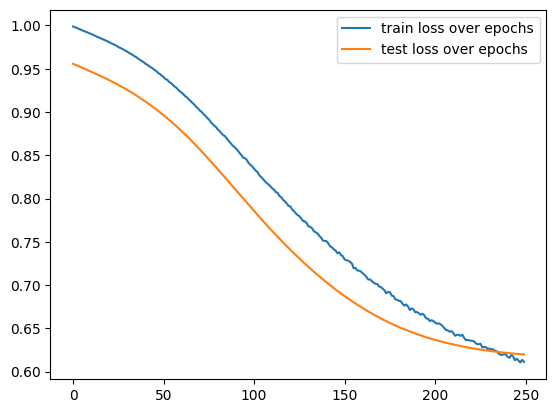

In [44]:
import matplotlib.pyplot as plt

plt.plot(train_losses_1,label="train loss over epochs")
plt.plot(test_losses_1,label="test loss over epochs")
plt.legend()

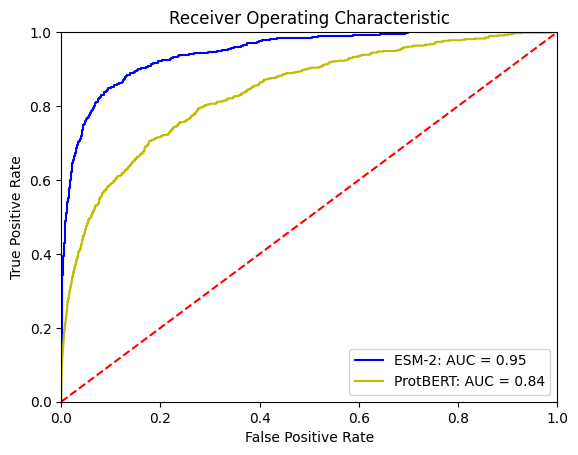

In [43]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'ESM-2: AUC = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'y', label = 'ProtBERT: AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()